In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import scipy.stats as stats
%matplotlib inline
import time
import os

from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import pandas as pd
import scipy.optimize
import scipy

import Utilities as utl

from random import randint
colors1 = []
import math

#All my functions
# import Utilities as utl

for i in range(1000):
    colors1.append('#%06X' % randint(0, 0xFFFFFF))    
    
from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

    
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'


import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Description of Experimental Data

- Lineage : AB, E, MS, IMA3(RNAi), ANI2(RNAi), BIG1(RNAi) aka C27D9.1(RNAi)
- Cell Stage : 8 - Cell , 16 - Cell

We can write AB lineage at 8 - Cell stage as AB8 (_{Lineage}{Cell Stage}_)

Now, the datasets we are loading in as NumPy arrays:

- **{Lineage}{Cell Stage}__exp.npy**: Raw Experimental Data that contains individual nucleolus size(FIB-1 molecules) vs time trajectories.  *Example: AB8_exp.npy*

- **{Lineage}{Cell Stage}.npy**: Cleaned and normalized Data that contains individual Nucleolus size(FIB-1 molecules) vs time trajectories. *Example: AB8.npy*

- **{Lineage}{Cell Stage}__assembly.npy**: Cleaned and normalized Data that contains individual nucleolus size(FIB-1 molecules) vs time trajectories up to maximum nucleolus size.(just the assembly data) *Example: AB8_assembly.npy*

- **Nucleoli_intensity_all_lineages.npy vs Nuclear_volume_all_lineages.npy**: Nucleolar intensity versus their respective nucleolar volume.(The intensity needs to be converted to FIB-1 molecules)

- **Nucleoli_intensity_AB8_stage.npy vs Nucleoli_volume_AB8_stage.npy**: Nucleolar intensity versus their respective nucleolar volume for AB lineage at 8 cell stage, achieved using RNAi perturbation.(The intensity needs to be converted to FIB-1 molecules)

# Calculating Parameters
## N_AB8 and Kd
Mathematical Equations for Parameter Calculation

*Log-Likelihood Function*
$$
\log L = -0.5 \cdot (N - 1) \cdot \log \left( \sum_{i=1}^{N} (M_{SS,i} - N_{\text{tot}} + K_d \cdot V_i)^2 \right)
$$


*Second Derivatives of the Log-Likelihood*
$$
\frac{\partial^2 \log L}{\partial K_d^2} = A
$$
$$
\frac{\partial^2 \log L}{\partial N_{\text{tot}}^2} = B
$$
$$
\frac{\partial^2 \log L}{\partial N_{\text{tot}} \partial K_d} = C
$$

*Errors in Estimates*
$$
\sigma_{N_{\text{tot}}} = \sqrt{-\frac{B}{|A \cdot B - C^2|}}
$$
$$
\sigma_{K_d} = \sqrt{-\frac{A}{|A \cdot B - C^2|}}
$$


In [3]:
import numpy as np

# Load Data
volumes = np.load('Experimental_Data/Nucleoli_volume_AB8_stage.npy')
intensities = np.load('Experimental_Data/Nucleoli_intensity_AB8_stage.npy')
intensities = intensities / 39.4

# Set up variables
delta_N_AB8 = 1000
delta_dissociation_constant = 1
N_AB8_grid = np.arange(0, 200000 + delta_N_AB8, delta_N_AB8)
dissociation_constant_grid = np.arange(0, 500 + delta_dissociation_constant, delta_dissociation_constant)
num_N_AB8 = len(N_AB8_grid)
num_dissociation_constants = len(dissociation_constant_grid)

likelihood_matrix = np.ones((num_N_AB8, num_dissociation_constants))

# Define log-likelihood function
def log_likelihood(volumes, intensities, N_AB8, dissociation_constant):
    num_samples = len(intensities)
    total_sum = np.sum((intensities - N_AB8 + dissociation_constant * volumes) ** 2)
    log_likelihood_value = -0.5 * (num_samples - 1) * np.log(total_sum)
    return log_likelihood_value

# Calculate likelihood
for i in range(num_N_AB8):
    for j in range(num_dissociation_constants):
        likelihood_matrix[i, j] = log_likelihood(volumes, intensities, N_AB8_grid[i], dissociation_constant_grid[j])

# Calculate derivatives
dLdKd = np.gradient(likelihood_matrix, delta_dissociation_constant, axis=1)
d2LdKd2 = np.gradient(dLdKd, delta_dissociation_constant, axis=1)
dLdN_AB8 = np.gradient(likelihood_matrix, delta_N_AB8, axis=0)
d2LdN_AB82 = np.gradient(dLdN_AB8, delta_N_AB8, axis=0)
d2LdN_AB8Kd = np.gradient(dLdKd, delta_N_AB8, axis=0)

# Find indices of maximum likelihood
max_likelihood_indices = np.unravel_index(np.argmax(likelihood_matrix), likelihood_matrix.shape)
A = d2LdKd2[max_likelihood_indices]
B = d2LdN_AB82[max_likelihood_indices]
C = d2LdN_AB8Kd[max_likelihood_indices]

# Calculate maximum likelihood estimates and errors
N_AB8_mle = N_AB8_grid[max_likelihood_indices[0]]
N_AB8_error_mle = np.sqrt(-A / (abs(A * B - C ** 2)))
dissociation_constant_mle = dissociation_constant_grid[max_likelihood_indices[1]]
dissociation_constant_error_mle = np.sqrt(-B / (abs(A * B - C ** 2)))

# Display results
print("N_AB8 = {:.2f} ± {:.2f}".format(N_AB8_mle, N_AB8_error_mle))
print("Kd = {:.2f} ± {:.2f}".format(dissociation_constant_mle, dissociation_constant_error_mle))



N_AB8 = 19000.00 ± 1462.98
Kd = 55.00 ± 5.95


## C (Concentration) and N

Formula for error propagation, which is for a division operation $ z = \frac{x}{y} $ or a multiplication operation $ z = xy $, where $ x $ and $ y $ are measured quantities with uncertainties $ \delta x $ and $ \delta y $, respectively, is given by:

$$
\delta z = z \sqrt{\left(\frac{\delta x}{x}\right)^2 + \left(\frac{\delta y}{y}\right)^2}
$$


*To Calculate $C$*

$$
C = C_{\text{AB8}} = \frac{N_{\text{AB8}}}{V_{\text{AB8}}}
$$




*For each lineage $ i $, $ N $ is calculated using:*

$$
N_i = C \times V_i
$$

In [25]:
# Function to calculate the standard error
def std_err(x, dx, y, dy):
    return round(x * y, 2), round((x * y) * np.sqrt((dx / x) ** 2 + (dy / y) ** 2), 2)

# Known parameters for AB8
N_AB8 = 19000
V_AB8 = 214.3
N_AB8_error = 1463
V_AB8_error = 36.4

# Calculate concentration C and its error
C = N_AB8 / V_AB8
C_error = np.sqrt((V_AB8_error / V_AB8) ** 2 + (N_AB8_error / N_AB8) ** 2) * C

print("C using N_AB8 and V_AB8:", f"{C:.2f} ± {C_error:.2f}\n")
print("N using C:\n")


# Define labels, volumes, and volume uncertainties
labels = ['MS8', 'E8', 'AB16', 'MS16', 'E16']
volumes = [201.6, 165.5, 137.7, 121.6, 93.7]
volume_uncert = [49.6, 38.3, 25.5, 18.3, 13.3]

# Initialize a DataFrame to store the results
concentration_results_df = pd.DataFrame(columns=['Label', 'N', 'N Error'])

# Calculate N using C and V for each label
for label, volume, volume_uncert in zip(labels, volumes, volume_uncert):
    N, N_error = std_err(C, C_error, volume, volume_uncert)
    concentration_results_df = pd.concat([concentration_results_df, pd.DataFrame({
        'Label': [label],
        'N': [int(N)],
        'N Error': [int(N_error)]
    })], ignore_index=True)

# Add the AB8 row separately since its data is already known
concentration_results_df = pd.concat([pd.DataFrame({
    'Label': ['AB8'],
    'N': [N_AB8],
    'N Error': [N_AB8_error]
}), concentration_results_df], ignore_index=True)

# Display the results
print(concentration_results_df)

C using N_AB8 and V_AB8: 88.66 ± 16.53

N using C:

  Label      N N Error
0   AB8  19000    1463
1   MS8  17874    5518
2    E8  14673    4361
3  AB16  12208    3208
4  MS16  10781    2583
5   E16   8307    1947


## Kp and Ka

In [26]:
############### PASSIVE MODEL #################

# Function to calculate the passive solution
def passive_solution(kplus_passive, kdiss, Ntot, V, delt, t_end):
    # Set up time array
    t = np.arange(0, t_end + delt, delt)
    m1 = np.zeros(len(t))  # nucleolus size

    # Calculate size prediction
    for i in range(len(t) - 1):
        m1[i + 1] = ((Ntot - kdiss * V) / 2) * (1 - np.exp(-2 * kplus_passive * t[i] / V))

    t_pred = t
    M_pred = m1
    return t_pred, M_pred

# Function to calculate the log-likelihood
def loglikelihood_global(M, kplus_passive, kdiss, Ntot, V):
    P = len(M)  # Number of data sets

    # Using params, compute one theoretical trajectory
    Tpred, Mpred = passive_solution(kplus_passive, kdiss, Ntot, V, 0.01, 50)

    sum_val = 0
    tot_pts = 0
    for j in range(P):
        current = M[j]
        O = current.shape[0]
        Mexp = current[:, 1]  # Experimental data
        Texp = current[:, 0]  # Experimental time

        # Correct time trajectories that begin before the average
        if Texp[0] < 0:
            Texp -= Texp[0]

        # Access correct elements from Mpred
        Mpred_order = [Mpred[np.argmin(np.abs(Tpred - t))] for t in Texp]

        sum_val += np.sum((Mexp - Mpred_order) ** 2)
        tot_pts += O

    L = -0.5 * (tot_pts - 1) * np.log(np.real(sum_val))
    return L


# Define labels and corresponding parameters
label = 'E16'
volume = 93.7
volume_uncert = 13.3
Ntot = 8307

kdiss = 55


M = np.load(f'Experimental_Data/{label}.npy', allow_pickle=True)

# Set up likelihood function grid
deltaK = 0.01
KGrid = np.arange(10, 20 + deltaK, deltaK)
likelihood = np.ones(len(KGrid))

# Calculate likelihood for different kplus values
for j in range(len(KGrid)):
    likelihood[j] = loglikelihood_global(M, KGrid[j], kdiss, Ntot, volume)


# Compute error on likelihood estimates
second_derivative = np.gradient(np.gradient(likelihood, deltaK), deltaK)
kplus_mle_idx = np.argmax(likelihood)
kplus_mle = KGrid[kplus_mle_idx]
kplus_error_mle = np.sqrt(-1 / second_derivative[kplus_mle_idx])

print('Kp:',np.round(kplus_mle, 2),'±',np.round(kplus_error_mle,2))

kplus_ka_mle = kplus_mle
kplus_ka_error_mle = kplus_error_mle

# # Plot likelihood function
# plt.figure()
# plt.plot(KGrid, np.real(likelihood))
# plt.xlabel('kplus')
# plt.ylabel('Log-likelihood')
# plt.title(f'Log-likelihood for {label}')
# plt.show()


###################################### ACTIVE MODEL #####################################

# Function to calculate the active solution
def active_solution(kplus_active, kdiss, Ntot, V, delt, t_end,t0, m0, offset=False):

    # Set up time array
    t = np.arange(0, t_end + delt, delt)
    m1 = np.zeros(len(t))  # nucleolus size
    m1[0] = m0  # initial size

    # Calculate size prediction
    for i in range(len(t) - 1):
        if t[i] < t0:
            m1[i + 1] = m0
        else:
            m1[i + 1] = m0 * np.exp(-(2 * kplus_active / (3 * V)) * ((t[i] - t0) ** 3)) + (Ntot - kdiss * V) / 2 * (1 - np.exp(-(2 * kplus_active / (3 * V)) * ((t[i] - t0) ** 3)))

    t_pred = t

    # Offsets size data 
    if offset:
        M_pred = m1 - m0 #Substracting the initial size from the prediction
    else:
        M_pred = m1

    return t_pred, M_pred

# Define the modified log-likelihood function
def loglikelihood_global(data, kplus_active, kdiss, Ntot, t0, volume, m0):
    
    num_data_sets = len(data)
    t_pred, M_pred = active_solution(kplus_active, kdiss, Ntot, volume, 0.01, 25,t0, m0, offset=True)

    sum_val = 0
    total_points = 0

    for dataset in data:
        time_exp = dataset[:, 0]
        M_exp = dataset[:, 1]
        total_points += len(time_exp)
        
        if time_exp[0] < 0:
            time_exp -= time_exp[0]

        M_pred_ordered = [M_pred[np.argmin(np.abs(t_pred - t))] for t in time_exp]

        sum_val += np.sum((M_exp - M_pred_ordered) ** 2)

    L = -0.5 * (total_points - 1) * np.log(np.real(sum_val))
    return L


# Define labels and corresponding parameters
label = 'E16'
volume = 93.7
volume_uncert = 13.3
Ntot = 8307
m0 = 0
t0 = 0

kdiss = 55


M = np.load(f'Experimental_Data/{label}.npy', allow_pickle=True)

# Set up likelihood function grid
deltaK = 0.01
KGrid = np.arange(0, 10 + deltaK, deltaK)
likelihood = np.ones(len(KGrid))

# Calculate likelihood for different kplus values
for j in range(len(KGrid)):
    likelihood[j] = loglikelihood_global(M, KGrid[j], kdiss, Ntot, t0, volume, m0)

# Compute error on likelihood estimates
second_derivative = np.gradient(np.gradient(likelihood, deltaK), deltaK)
kplus_mle_idx = np.argmax(likelihood)
kplus_mle = KGrid[kplus_mle_idx]
kplus_error_mle = np.sqrt(-1 / second_derivative[kplus_mle_idx])

print('Ka:',np.round(kplus_mle, 2),'±',np.round(kplus_error_mle,2))

# # Plot likelihood function
# plt.figure()
# plt.plot(KGrid, np.real(likelihood))
# plt.xlabel('kplus')
# plt.ylabel('Log-likelihood')
# plt.title(f'Log-likelihood for {label}')
# plt.show()

Kp: 13.63 ± 1.86
Ka: 2.04 ± 0.46


## t0

*Mathematical Equations for Parameter Calculation*

*Modified Log-Likelihood Function*
$$
\log L = -0.5 \cdot (N_{\text{total}} - 1) \cdot \log \left( \sum_{i=1}^{N_{\text{total}}} (M_{\text{exp}, i} - M_{\text{pred}, i})^2 \right)
$$
where
$$
M_{\text{pred}}(t) = 
\left\{
    \begin{array}{lr}
        M_0 & \text{if } t< t_0\\
        M_0 e^{-\frac{2K_a(t-t_0)^3}{3V}} + \frac{N-K_dV}{2}\bigg( 1 - e^{-\frac{2K_a(t-t_0)^3}{3V}}\bigg) & \text{if } t\geq t_0
    \end{array}
\right\}
$$


*Error Calculation for $ t_0 $*
$$
\sigma_{t_0} = \sqrt{-\frac{1}{\frac{\partial^2 \log L}{\partial t_0^2}}}
$$

where $ \frac{\partial^2 \log L}{\partial T_0^2} $ is the second derivative of the log-likelihood function with respect to $ T_0 $.


In [27]:
# Load Data
traj_matrix = np.load('Experimental_Data/AB8_assembly.npy', allow_pickle=True)

# Define the modified log-likelihood function
def log_likelihood_global(data, kplus_active, kdiss, Ntot, t0, volume, m0):
    
    num_data_sets = len(data)
    t_pred, M_pred = active_solution(kplus_active, kdiss, Ntot, volume, 0.01, 25,t0, m0, offset=True)

    sum_val = 0
    total_points = 0


    for dataset in data:
        time_exp = dataset[:, 0]
        M_exp = dataset[:, 1]
        total_points += len(time_exp)
        
        if time_exp[0] < 0:
            time_exp -= time_exp[0]

        M_pred_ordered = [M_pred[np.argmin(np.abs(t_pred - t))] for t in time_exp]

        sum_val += np.sum((M_exp - M_pred_ordered) ** 2)
#         plt.plot(t_pred,M_pred,c='k',lw=3)
#         plt.plot(time_exp,M_exp)

    L = -0.5 * (total_points - 1) * np.log(np.real(sum_val))
    return L

def active_solution(kplus_active, kdiss, Ntot, V, delt, t_end,t0, m0, offset=False):

    # Set up time array
    t = np.arange(0, t_end + delt, delt)
    m1 = np.zeros(len(t))  # nucleolus size
    m1[0] = m0  # initial size

    # Calculate size prediction
    for i in range(len(t) - 1):
        if t[i] < t0:
            m1[i + 1] = m0
        else:
            m1[i + 1] = m0 * np.exp(-(2 * kplus_active / (3 * V)) * ((t[i] - t0) ** 3)) + (Ntot - kdiss * V) / 2 * (1 - np.exp(-(2 * kplus_active / (3 * V)) * ((t[i] - t0) ** 3)))

    t_pred = t

    # Offsets size data 
    if offset:
        M_pred = m1 - m0 #Substracting the initial size from the prediction
    else:
        M_pred = m1

    return t_pred, M_pred

# Define labels, t0 values, and corresponding parameters
labels = ['AB8', 'MS8', 'E8', 'AB16', 'MS16','IMA3','ANI2','BIG1']
ntots = [19000, 17874, 14673, 12209, 10781,19000,19000,19000]
volumes = [214.3, 201.6, 165.5, 137.7, 121.6,148.9,186.9,311.4]
M0 = [236.1356, 165.2597, 318.719, 184.5193, 392.8011,1718.1333,326.9839255499154,65.964467] #from lineage specific averages


# 1718.133364097831

# 195.5329949238579

# 1718.133364097831
# 326.9839255499154
# 195.5329949238579

# [256.1356121827411,
#  165.2597171319797,
#  318.71985050761424,
#  184.51931697969545,
#  14.746192893401016] #different for MS16
# M0 = [0 for i in range(8)]

kplus_active = 2.04
kdiss = 55

# Initialize a DataFrame to store the results
results_df = pd.DataFrame(columns=['Label', 't0', 't0 Error', 'Number of Trajectories'])

# Calculate T0 and T0 error for each label
for m0, label, Ntot, volume in zip(M0, labels, ntots, volumes):
    traj_matrix = np.load(f'Experimental_Data/{label}_assembly.npy', allow_pickle=True)
    
    delta_t0 = 0.1
    t0_grid = np.arange(-5, 3+delta_t0, delta_t0)
    # Calculate likelihood for different t0 values
    likelihood = np.ones(len(t0_grid))
    for idx, t0 in enumerate(t0_grid):
        likelihood[idx] = log_likelihood_global(traj_matrix, kplus_active, kdiss, Ntot, t0, volume, m0)

    # Compute error on likelihood estimates
    second_derivative = np.gradient(np.gradient(likelihood, delta_t0), delta_t0)
    t0_mle_idx = np.argmax(likelihood)
    T0_mle = t0_grid[t0_mle_idx]
    T0_error_mle = np.sqrt(-1 / second_derivative[t0_mle_idx])
    
    # Store the results
    results_df = pd.concat([results_df, pd.DataFrame({
        'Label': [label],
        't0': [np.round(T0_mle,1)],
        't0 Error': [np.round(T0_error_mle,1)],
        'Number of Trajectories': [len(traj_matrix)]
    })], ignore_index=True)

#display the results
print(results_df)

  Label   t0  t0 Error Number of Trajectories
0   AB8 -0.4       0.1                     87
1   MS8  1.0       0.2                     22
2    E8  1.1       0.2                     24
3  AB16  2.1       0.1                    180
4  MS16  1.3       0.3                     24
5  IMA3 -3.2       0.2                     29
6  ANI2 -2.5       0.1                     28
7  BIG1 -3.4       0.2                     23


# Figures

## Figure 2

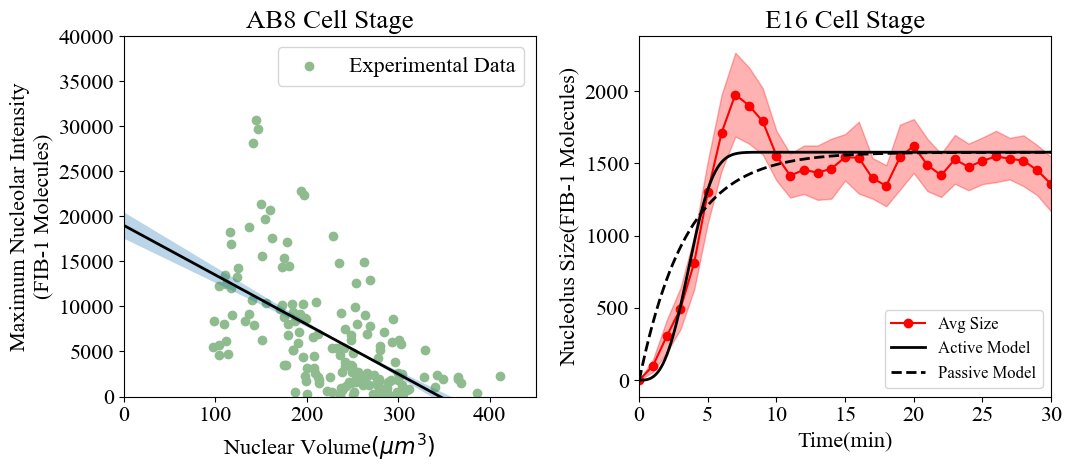

In [28]:
V_ab8 = np.load('Experimental_Data/Nucleoli_volume_AB8_stage.npy')
M_ab8 = np.load('Experimental_Data/Nucleoli_intensity_AB8_stage.npy')
M_ab8 = M_ab8/39.4

###### Get Shaded Region #######

def size_M(Ntot, Kd,V):
    return Ntot - Kd * V 

v_array = np.arange(0,max(V_ab8),0.1)
m_array = np.array([size_M(19000.00,55.00,i) for i in v_array])
m_array_1 = np.array([size_M(19000.00-1462.98,55.00-5.95,i) for i in v_array])
m_array_2 = np.array([size_M(19000.00+1462.98,55.00+5.95,i) for i in v_array])


###########PLOTTING ##################

mpl.rcParams.update({'font.size':16})
plt.figure(figsize=(11,5))

plt.subplot(1,2,1)
plt.scatter(V_ab8,M_ab8,color='darkseagreen',label='Experimental Data')
plt.plot(v_array,m_array,'k',lw=2)
plt.fill_between(v_array, m_array_1, m_array_2, alpha=0.3)
plt.title('AB8 Cell Stage')
plt.xlabel('Nuclear Volume$(\mu m^3)$')
plt.ylabel('Maximum Nucleolar Intensity\n(FIB-1 Molecules)')
plt.legend()
plt.ylim([0,40000])
plt.xlim([0,450])


####################### IMPORTING E16 DATA ################

L = np.load(f"Experimental_Data/E16.npy",allow_pickle=True)
all_times = []
all_lengths = []
for j in range(len(L)):
    current = L[j]
    O = current.shape[0]
    Mexp = current[:, 1]  # Experimental data
    Texp = current[:, 0]  # Experimental time
    all_times.append(Texp)
    all_lengths.append(Mexp)

a,b,c = utl.get_mean_traj(all_times,all_lengths,time_interval=1,standard_deviation=False)


####################### Getting Active and passive model prediction ##################
ac_T, ac_M = utl.active_solution(kplus_active=2.04, kdiss=55, Ntot=8307, V=93.7, delt=1e-3, 
                                 t_end=35,t0=0, m0=0, offset=False)
ps_T, ps_M = utl.passive_solution(kplus_passive=13.68, kdiss=55, Ntot=8307, V=93.7, delt=1e-3, 
                                  t_end=35, m0=0, offset=False)


plt.subplot(1,2,2)
plt.plot(a - a[0], b - b[0], '-o', label=f'Avg Size', color='red')
plt.fill_between(a - a[0], b - b[0] - c, b - b[0] + c, alpha=0.3, color='red')
plt.plot(ac_T,ac_M,c='k',lw=2,label='Active Model')
plt.plot(ps_T,ps_M,'--',c='k',lw=2,label='Passive Model')
plt.legend(fontsize=12,loc=4)
plt.title('E16 Cell Stage')
plt.xlabel('Time(min)')
plt.ylabel('Nucleolus Size(FIB-1 Molecules)')
plt.xlim([0,30])


plt.tight_layout()

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# plt.savefig('Figures/Chapter_4/Chapter_4_Figure1.pdf', transparent=True, bbox_inches='tight')

plt.show()

## Figure 3

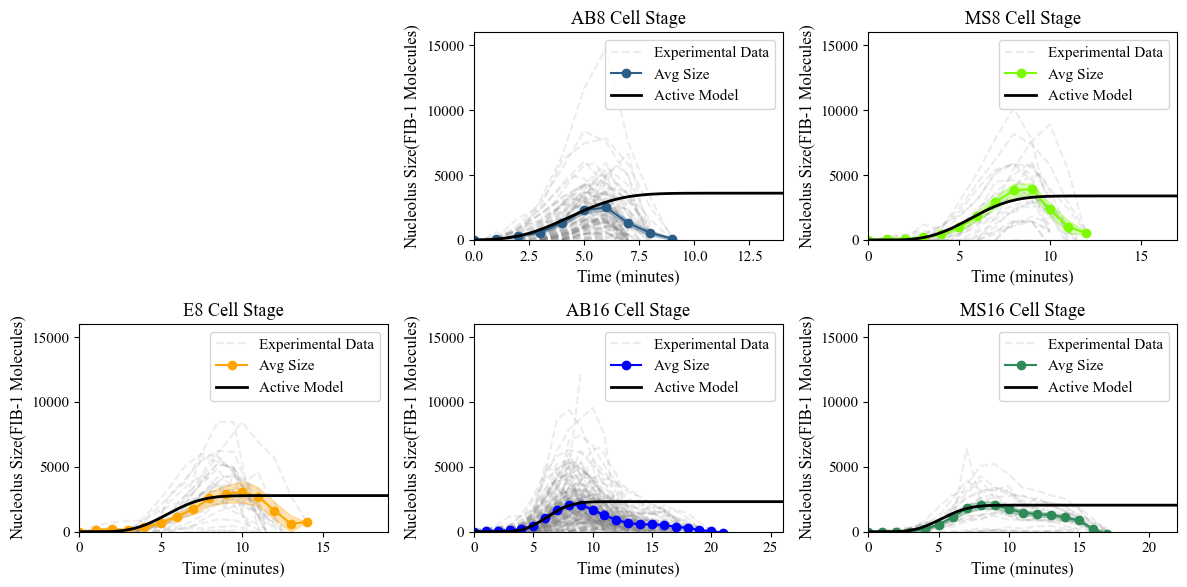

In [29]:

plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'Times New Roman'

labels = ['AB8', 'MS8', 'E8', 'AB16', 'MS16', 'E16','IMA3','ANI2','BIG1']
colors = ['#2b5d87','lawngreen', 'orange', 'blue','seagreen','red','#86b2d8','#3d84bf','royalblue','#2b5d87']
t0_s = [-0.4, 1, 1.1, 2.1,1.3, 0,-3.2,-2.4,-3.4]

ntots = [19000, 17874, 14673, 12209, 10781, 8307,19000,19000,19000,19000]
volumes = [214.3, 201.6, 165.5, 137.7,121.6,93.7,148.8767215,186.9308994,311.3973321,214.3]

plt.figure(figsize=(12,6))

for i in range(len(labels)-4):
    L = np.load(f"Experimental_Data/{labels[i]}.npy",allow_pickle=True)
    all_times = []
    all_lengths = []
    plt.subplot(2,3,i+2)
    for j in range(len(L)):
        current = L[j]
        O = current.shape[0]
        Mexp = current[:, 1]  # Experimental data
        Texp = current[:, 0]  # Experimental time
                
        Texp = np.round(Texp,2)
        
        if Texp[0] < 0:
            Texp -= Texp[0]
            
        all_times.append(Texp)
        all_lengths.append(Mexp)
        plt.plot(all_times[-1],all_lengths[-1],'--',color='grey',alpha=0.15)
        
    plt.plot(all_times[-1],all_lengths[-1],'--',color='grey',alpha=0.15,label='Experimental Data')
        
    times,lengths,errors = utl.get_mean_traj(all_times,all_lengths,time_interval=1,standard_deviation=False)    
    
    upper_error_bound_raw = np.array(lengths) + np.array(errors)
    lower_error_bound_raw = np.array(lengths) - np.array(errors)

    
    plt.plot(times-times[0], lengths-lengths[0],'-o', label=f'Avg Size',color=colors[i])
    
    # Fill the area between the upper and lower error bounds for raw data with a color
    plt.fill_between(times-times[0], lower_error_bound_raw, upper_error_bound_raw, alpha=0.3,color=colors[i])

    
    ac_T, ac_M = utl.active_solution(kplus_active=2.04, kdiss=55, Ntot=ntots[i], V=volumes[i], delt=1e-3, 
                                 t_end=35,t0=t0_s[i], m0=lengths[0], offset=False)
    
    plt.plot(ac_T,ac_M,c='k',lw=2,label='Active Model')
    
    plt.title(f'{labels[i]} Cell Stage')
    plt.xlabel('Time (minutes)',fontsize=12)
    plt.ylabel('Nucleolus Size(FIB-1 Molecules)',fontsize=12)
    plt.legend(fontsize=11)
    plt.ylim(0,16000)
    plt.xlim(0,np.max(times-times[0])+5)
# 


    
plt.tight_layout()
# plt.savefig('Figures/Chapter_4/Chapter_4_Figure2.pdf', transparent=True, bbox_inches='tight')

plt.show()

## Figure 4

/Users/nk5671/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nk5671/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/0d/bpjz6bj91vv8m15ms2svz2p01nft7w/T/ipykernel_38621/2707051416.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


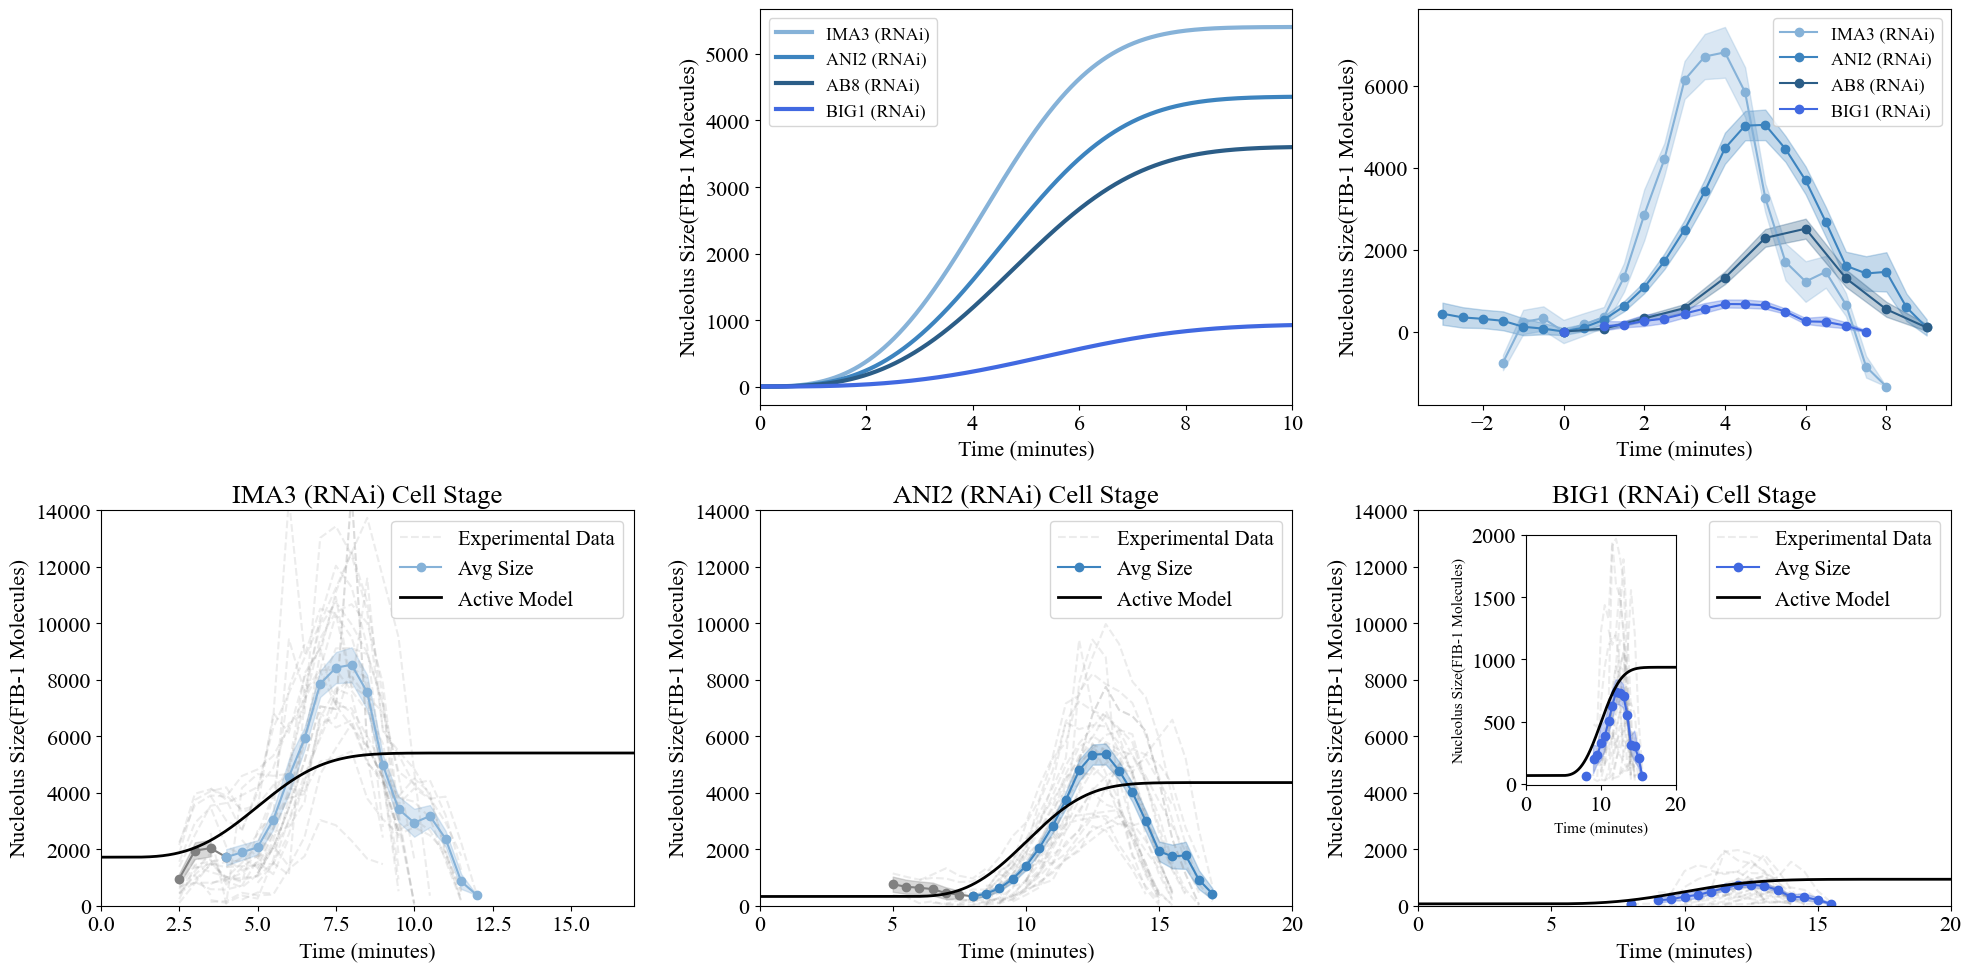

In [30]:
mpl.rcParams.update({'font.size':16})
plt.figure(figsize=(20,10))


ntots = [19000,19000,19000,19000]
volumes = [148.8767215,186.9308994,214.3,311.3973321]
colors = ['#86b2d8','#3d84bf','#2b5d87','royalblue']
t0_s = [-3.2,-2.5,-0.4,-3.4]
labels = ['IMA3','ANI2','AB8','BIG1']
plt.subplot(2,3,2)
for j in range(len(labels)):
    ac_T, ac_M = utl.active_solution(kplus_active=2.0, kdiss=55, Ntot=ntots[j], V=volumes[j], delt=1e-3, 
                                 t_end=35,t0=0, m0=0, offset=False)
    
    
    plt.plot(ac_T,ac_M,lw=3,label=f'{labels[j]} (RNAi)',color=colors[j])
    plt.xlabel('Time (minutes)',fontsize=16)
    plt.ylabel('Nucleolus Size(FIB-1 Molecules)',fontsize=16)
    plt.legend(fontsize=13)
    plt.xlim(0,10)

###############################################################################################################

plt.subplot(2,3,3)
start_p = [3, 6, 0,0]
for i in range(len(labels)):
    L = np.load(f"Experimental_Data/{labels[i]}_exp.npy",allow_pickle=True)
    all_times = []
    all_lengths = []
    for j in range(len(L)):
        current = L[j]
        O = current.shape[0]
        Mexp = current[:, 1]  # Experimental data
        Texp = current[:, 0]  # Experimental time
        
        Texp = np.round(Texp,2)
                
#         if Texp[0] < 0:
#             Texp -= Texp[0]
            
        all_times.append(Texp)
        all_lengths.append(Mexp)
#         plt.plot(all_times[-1],all_lengths[-1],'--',color='grey',alpha=0.15)
    
#     plt.plot(all_times[-1],all_lengths[-1],'--',color='grey',alpha=0.15,label='Experimental Data')

    if i==2:
        a,b,c = utl.get_mean_traj(all_times,all_lengths,time_interval=1,standard_deviation=False)
    else:
        a,b,c = utl.get_mean_traj(all_times,all_lengths,time_interval=0.5,standard_deviation=False)
    b = np.array(b)
    c = np.array(c)

#     plt.errorbar(a - a[0], b - b[0], yerr=c, fmt='-o', label=f'{labels[i]} Cell Stage', color=colors[i],
#                  lw=1, markersize=4, capsize=5, capthick=1, elinewidth=1, markeredgewidth=1)

    plt.plot(a-a[start_p[i]] , b-b[start_p[i]], '-o', color=colors[i],label=f'{labels[i]} (RNAi)')
    plt.fill_between(a-a[start_p[i]] , b-b[start_p[i]]  - c, b-b[start_p[i]]  + c, alpha=0.3, color=colors[i])
    plt.xlabel('Time (minutes)',fontsize=16)
    plt.ylabel('Nucleolus Size(FIB-1 Molecules)',fontsize=16)
    plt.legend(fontsize=13)
################################################################################################################

labels = ['AB8', 'MS8', 'E8', 'AB16', 'MS16', 'E16','IMA3','ANI2','BIG1']
ntots = [19000, 17874, 14673, 12209, 10781, 8307,19000,19000,19000,19000]
volumes = [214.3, 201.6, 165.5, 137.7,121.6,93.7,148.8767215,186.9308994,311.3973321,214.3]
colors = ['#2b5d87','lawngreen', 'orange', 'blue','seagreen','red','#86b2d8','#3d84bf','royalblue','#2b5d87']
t0_s = [-0.4, 1, 1.1, 2,1.3, 0,-3.2,-2.5,-3.4]
start_p = [3, 6, 0]
for i in range(6,len(labels)):
    

    L = np.load(f"Experimental_Data/{labels[i]}_exp.npy",allow_pickle=True)
    all_times = []
    all_lengths = []
    plt.subplot(2,3,i-5+3)
    for j in range(len(L)):
        current = L[j]
        O = current.shape[0]
        Mexp = current[:, 1]  # Experimental data
        Texp = current[:, 0]  # Experimental time
        
        Texp = np.round(Texp,2)
                
#         if Texp[0] < 0:
#             Texp -= Texp[0]
            
        all_times.append(Texp)
        all_lengths.append(Mexp)
        plt.plot(all_times[-1],all_lengths[-1],'--',color='grey',alpha=0.15)
        
    
    plt.plot(all_times[-1],all_lengths[-1],'--',color='grey',alpha=0.15,label='Experimental Data')

    a,b,c = utl.get_mean_traj(all_times,all_lengths,time_interval=0.5,standard_deviation=False)
    b = np.array(b)
    c = np.array(c)

#     plt.errorbar(a - a[0], b - b[0], yerr=c, fmt='-o', label=f'{labels[i]} Cell Stage', color=colors[i],
#                  lw=1, markersize=4, capsize=5, capthick=1, elinewidth=1, markeredgewidth=1)

    #grey area
    plt.plot(a[:start_p[i-6]+1] , b[:start_p[i-6]+1], '-o', color='grey')
    plt.fill_between(a[:start_p[i-6]] , b[:start_p[i-6]]  - c[:start_p[i-6]], b[:start_p[i-6]]  + c[:start_p[i-6]], alpha=0.3, color='grey')

    #after grey
    plt.plot(a[start_p[i-6]:] , b[start_p[i-6]:], '-o', color=colors[i],label='Avg Size')
    plt.fill_between(a[start_p[i-6]:] , b[start_p[i-6]:]  - c[start_p[i-6]:], b[start_p[i-6]:]  + c[start_p[i-6]:], alpha=0.3, color=colors[i])

    ac_T, ac_M = utl.active_solution(kplus_active=2.0, kdiss=55, Ntot=ntots[i], V=volumes[i], delt=1e-3, 
                                t_end=35,t0=a[start_p[i-6]]+t0_s[i], m0=b[start_p[i-6]], offset=False)
    


    
    
    plt.plot(ac_T,ac_M,c='k',lw=2,label='Active Model')
    
    plt.title(f'{labels[i]} (RNAi) Cell Stage')
    plt.xlabel('Time (minutes)',fontsize=16)
    plt.ylabel('Nucleolus Size(FIB-1 Molecules)',fontsize=16)
    plt.legend(fontsize=15)
    plt.ylim(0,14000)
    
    if i==6:
        plt.xlim(0,17)
    else:
        plt.xlim(0,20)
    
   
    
    if i==len(labels)-1:
        #inset_ax = plt.f
        inset_ax = plt.axes([0.77, 0.2, 0.075, 0.25])  # Define inset position and size [x, y, width, height]

        for k in range(len(all_lengths)):
            inset_ax.plot(all_times[k],all_lengths[k],'--',color='grey',alpha=0.15)
            
        inset_ax.plot(a , b, '-o', color=colors[i],label='Avg Size')
        inset_ax.fill_between(a , b  - c, b  + c, alpha=0.3, color=colors[i])

        
        inset_ax.plot(ac_T,ac_M,c='k',lw=2,label='Active Model')

        #Customize the inset axis
        inset_ax.set_xlabel('Time (minutes)', fontsize=11)
        inset_ax.set_ylabel('Nucleolus Size(FIB-1 Molecules)', fontsize=11)
        inset_ax.set_xlim([0,20])
        inset_ax.set_ylim([-10,2e3])
     
    


plt.tight_layout()

# plt.savefig('Figures/Chapter_4/Chapter_4_Figure3_1.pdf', transparent=True, bbox_inches='tight')
# plt.savefig('Figures_For_Lishi/RNAi.pdf', transparent=True, bbox_inches='tight')
plt.show()

## Figure 5

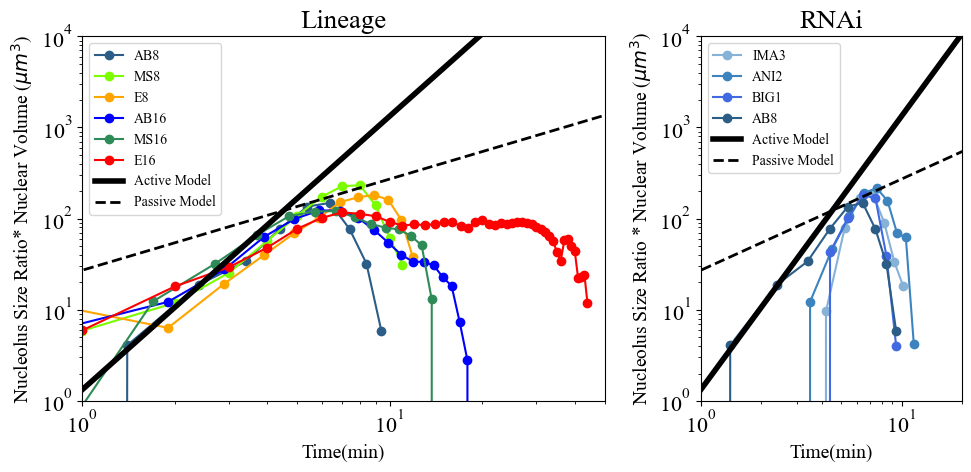

In [31]:
mpl.rcParams.update({'font.size':16})
import matplotlib as mpl

# mpl.rcParams['pdf.fonttype'] = 42
# mpl.rcParams['ps.fonttype'] = 42

save_path = '/Users/nk5671/Dropbox/Nucleolus_size_regulation/Paper/Figure_PDFS/lineage_sem'


# t0_s = [-0.4,1,1.1,2,1.3,0.1]
# labels = ['AB8','MS8','E8','AB16','MS16','E16']
# colors = ['#2b5d87','lawngreen','orange','blue','seagreen','red']
# volumes = [214.3,201.6,165.5,137.7,121.6,93.7]
# ntots = [19000,17874,14673,12209,10781,8307]



# labels = ['AB8', 'AB16', 'MS8', 'MS16', 'E8', 'E16','IMA3','ANI2','BIG1','AB8']
# t0_s = [-0.4, 2, 1, 1.3, 1.1, 0,-2.7,-2.5,-3.4,-0.4]
# ntots = [19000, 12209, 17874, 10781, 14673, 8307,19000,19000,19000,19000]
# colors = ['#2b5d87', 'blue', 'lawngreen', 'seagreen', 'orange', 'red','#86b2d8','#3d84bf','royalblue','#2b5d87']
# volumes = [214.3, 137.7, 201.6, 121.6, 165.5, 93.7,148.8767215,186.9308994,311.3973321,214.3]

labels = ['AB8', 'MS8','E8','AB16','MS16','E16','IMA3','ANI2','BIG1','AB8']
t0_s = [-0.4, 1, 1.1, 2.1,1.3, 0,-3.2,-2.5,-3.4,-0.4]
ntots = [19000, 17874, 14673, 12209, 10781, 8307,19000,19000,19000,19000]
colors = ['#2b5d87','lawngreen', 'orange', 'blue','seagreen','red','#86b2d8','#3d84bf','royalblue','#2b5d87']
volumes = [214.3, 201.6, 165.5, 137.7,121.6,93.7,148.8767215,186.9308994,311.3973321,214.3]

# start_p = [0,0,0,0,0,0,3, 6, 0]


# # Create a subplot with 1 row and 2 columns
# plt.figure(figsize=(10, 5))

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


# Create a subplot with 1 row and 2 columns with adjusted size
fig, axs = plt.subplots(1, 2, figsize=(10,5), gridspec_kw={'width_ratios': [2, 1]})

axs[0].set_title('Lineage')
plt.subplot(1, 2, 1)
    
for _ in range(0,len(volumes)-4):
    
    V = volumes[_] 
    t0 = t0_s[_]
    Ntot = ntots[_]
    kdiss = 55
    label = labels[_]
    color = colors[_]

    M = np.load(f"Experimental_Data/{label}.npy",allow_pickle=True)
    
    

    P = len(M)
    all_times = []
    all_lengths = []
    
#     plt.figure()
    for j in range(P):
        current = M[j]
        O = current.shape[0]
        Mexp = current[:, 1]  # Experimental data
        Texp = current[:, 0]  # Experimental time
        
        Texp = np.round(Texp,2)
        
        if Texp[0] < 0:
            Texp -= Texp[0]
            
#         if all(i>=0 for i in Mexp):
        all_times.append(Texp)
        all_lengths.append(Mexp)
        
        
        #plot raw trajectories
        
#         if all(i>=10 for i in Texp):
#         plt.plot(Texp,Mexp,'--',label='Exp',color='grey',alpha=0.15)

#     plt.show()


    global_min = 10
    for i in range(len(all_times)):
        if min(all_times[i]) < global_min:
            global_min = min(all_times[i])

    global_max = 0
    for i in range(len(all_times)):
        if max(all_times[i]) > global_max:
            global_max = max(all_times[i])

    tpoints = np.arange(global_min, global_max + 0.5, 1)

    lengths = []
    times = []
    errors = []
    for t in tpoints:
        lens = []
        for i in range(len(all_times)):
            if t in all_times[i]:
                var = all_lengths[i][np.where(all_times[i] == t)]
                if len(var) > 0:
                    var = all_lengths[i][np.where(all_times[i] == t)][0]
                lens.append(var)

        if len(lens)>1:
            lengths.append(np.mean(lens))
            errors.append(np.std(lens)/np.sqrt(len(lens)))  #/np.sqrt(len(lens))
            times.append(t)
            #print('Time:', t, 'length:', np.mean(lens),'errors',errors[-1])
            
    lengths = lengths - lengths[0]
    times = times-times[0]

#     a,b,c = get_mean_traj(all_times,all_lengths,time_interval=1,standard_deviation=False)
    
#     a = np.array(a)
#     b = np.array(b)
#     c = np.array(c)


#     lengths = b - b[0]
#     times = a - a[0]

    def nucleolus_size_ratio(lengths,V,Ntot,kdiss):
        sol = []
        for i in lengths:
            sol.append((i-lengths[0])*V/((Ntot-kdiss*V)/2-lengths[0]))
        return np.array(sol)
    
    
    ##### WITH MODFICATION
    
#     def nucleolus_size_ratio(lengths,V,Ntot,kdiss):
#         sol = []
#         for i in lengths:
#             sol.append((i/(Ntot-kdiss*V)))
#         return np.array(sol)
                       
                       
    
    def nucleolus_time_ratio(times):
        sol = []
        for i in times:
            sol.append(i/V)
        return np.array(sol)
    
    rel_sizes = nucleolus_size_ratio(lengths,V,Ntot,kdiss)
    rel_times = nucleolus_time_ratio(times)
    
#     print(rel_sizes)
                       
        
#     tp = [(i-t0)/V**(1/3) for i in times]
    tp = [(i-t0) for i in times]
    plt.loglog(tp,rel_sizes,'-o', label=f'{label}',color=color)
      
    kplus_active = 2
    def rhs(t,V):
        return (2*kplus_active*t**3)/(3)

    def rhs_p(t,V):
        return (2*13.6*t)
    
    tp = np.arange(0.01,50,0.01)
    yp = np.array([rhs(i,V) for i in tp])
    ypp = np.array([rhs_p(i,V) for i in tp])
    
    
    if _ == 5:
        plt.loglog(tp,yp,label='Active Model',c='black',lw=4)
        plt.loglog(tp,ypp,'--',label='Passive Model',c='black',lw=2)
        #plt.loglog(tp,yp,label='Active Model',c='black',lw=4)
#     plt.loglog(tp,yp,c='black',lw=4)

# Customize the layout for the first subplot
# plt.xlabel(r'$\frac{(t-t_0)}{V^{1/3}}$', fontsize=15)
plt.xlabel('Time(min)', fontsize=14)
plt.ylabel('Nucleolus Size Ratio* Nuclear Volume ($\mu m^3$)', fontsize=14)

plt.xlim([1, 50])
plt.ylim([1,1e4])
plt.legend(fontsize=10)


######################################### RNAI ###########################################
axs[1].set_title('RNAi')
# Plotting the second subplot
plt.subplot(1, 2, 2)

# Loop for 'IMA3', 'ANI2', and 'BIG1' only
for idx, label in enumerate(['IMA3', 'ANI2', 'BIG1','AB8']):
    V = volumes[idx + 6]
    t0 = t0_s[idx + 6]
    Ntot = ntots[idx + 6]
    kdiss = 55
    color = colors[idx + 6]

    M = np.load(f"Experimental_Data/{label}.npy", allow_pickle=True)

    P = len(M)
    all_times = []
    all_lengths = []

    for j in range(P):
        current = M[j]
        O = current.shape[0]
        Mexp = current[:, 1]
        Texp = current[:, 0]

        Texp = np.round(Texp, 2)

        if Texp[0] < 0:
            Texp -= Texp[0]

        all_times.append(Texp)
        all_lengths.append(Mexp)

    global_min = 10
    for i in range(len(all_times)):
        if min(all_times[i]) < global_min:
            global_min = min(all_times[i])

    global_max = 0
    for i in range(len(all_times)):
        if max(all_times[i]) > global_max:
            global_max = max(all_times[i])

    tpoints = np.arange(global_min, global_max + 0.5, 1)

    lengths = []
    times = []
    errors = []
    for t in tpoints:
        lens = []
        for i in range(len(all_times)):
            if t in all_times[i]:
                var = all_lengths[i][np.where(all_times[i] == t)]
                if len(var) > 0:
                    var = all_lengths[i][np.where(all_times[i] == t)][0]
                lens.append(var)

        if len(lens) > 1:
            lengths.append(np.mean(lens))
            errors.append(np.std(lens) / np.sqrt(len(lens)))
            times.append(t)

    lengths = lengths - lengths[0]
    times = times - times[0]

#     a,b,c = get_mean_traj(all_times,all_lengths,time_interval=1,standard_deviation=False)
    
#     a = np.array(a)
#     b = np.array(b)
#     c = np.array(c)


#     lengths = b - b[0]
#     times = a - a[0]

    def nucleolus_size_ratio(lengths,V,Ntot,kdiss):
        sol = []
        for i in lengths:
            sol.append((i-lengths[0])*V/((Ntot-kdiss*V)/2-lengths[0]))
        return np.array(sol)
    
    
    ##### WITH MODFICATION
    
#     def nucleolus_size_ratio(lengths,V,Ntot,kdiss):
#         sol = []
#         for i in lengths:
#             sol.append((i/(Ntot-kdiss*V)))
#         return np.array(sol)
                       
                       
    
    def nucleolus_time_ratio(times):
        sol = []
        for i in times:
            sol.append(i/V)
        return np.array(sol)
    
    rel_sizes = nucleolus_size_ratio(lengths,V,Ntot,kdiss)
    rel_times = nucleolus_time_ratio(times)
    
#     print(rel_sizes)
                       
        
#     tp = [(i-t0)/V**(1/3) for i in times]
    tp = [(i-t0) for i in times]
    plt.loglog(tp,rel_sizes,'-o', label=f'{label}',color=color)
      
    kplus_active = 2.0
    def rhs(t,V):
        return (2*kplus_active*t**3)/(3)

    def rhs_p(t,V):
        return (2*13.6*t)
    
    tp = np.arange(0.01,50,0.01)
    yp = np.array([rhs(i,V) for i in tp])
    
    ypp = np.array([rhs_p(i,V) for i in tp])
    
    
    if label=='AB8':
        plt.loglog(tp,yp,label='Active Model',c='black',lw=4)
        plt.loglog(tp,ypp,'--',label='Passive Model',c='black',lw=2)

# Customize the layout for the second subplot
# plt.xlabel(r'$\frac{k_+ t^3}{3}$', fontsize=15)
# plt.ylabel(r'$\frac{MV}{N-k_d V}$', fontsize=15)


plt.xlabel('Time(min)', fontsize=14)
plt.ylabel('Nucleolus Size Ratio * Nuclear Volume ($\mu m^3$)', fontsize=14)

plt.xlim([1, 20])
plt.ylim([1,1e4])
plt.legend(fontsize=10)

                      
    
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


# Save or show the plot
# plt.savefig('x-axis-tbyV^(1by3).png', dpi=300, bbox_inches='tight')
# save_path = '/Users/nk5671/Dropbox/Nucleolus_size_regulation/Paper/Figure_PDFS'
# plt.savefig(f'{save_path}/Figure_5.pdf',bbox_inches='tight',transparent=True)

plt.tight_layout()
# plt.savefig('Figures/Chapter_4/Chapter_4_Figure4.pdf', transparent=True, bbox_inches='tight')
plt.show()

# Supplement Figures
## Figure S1

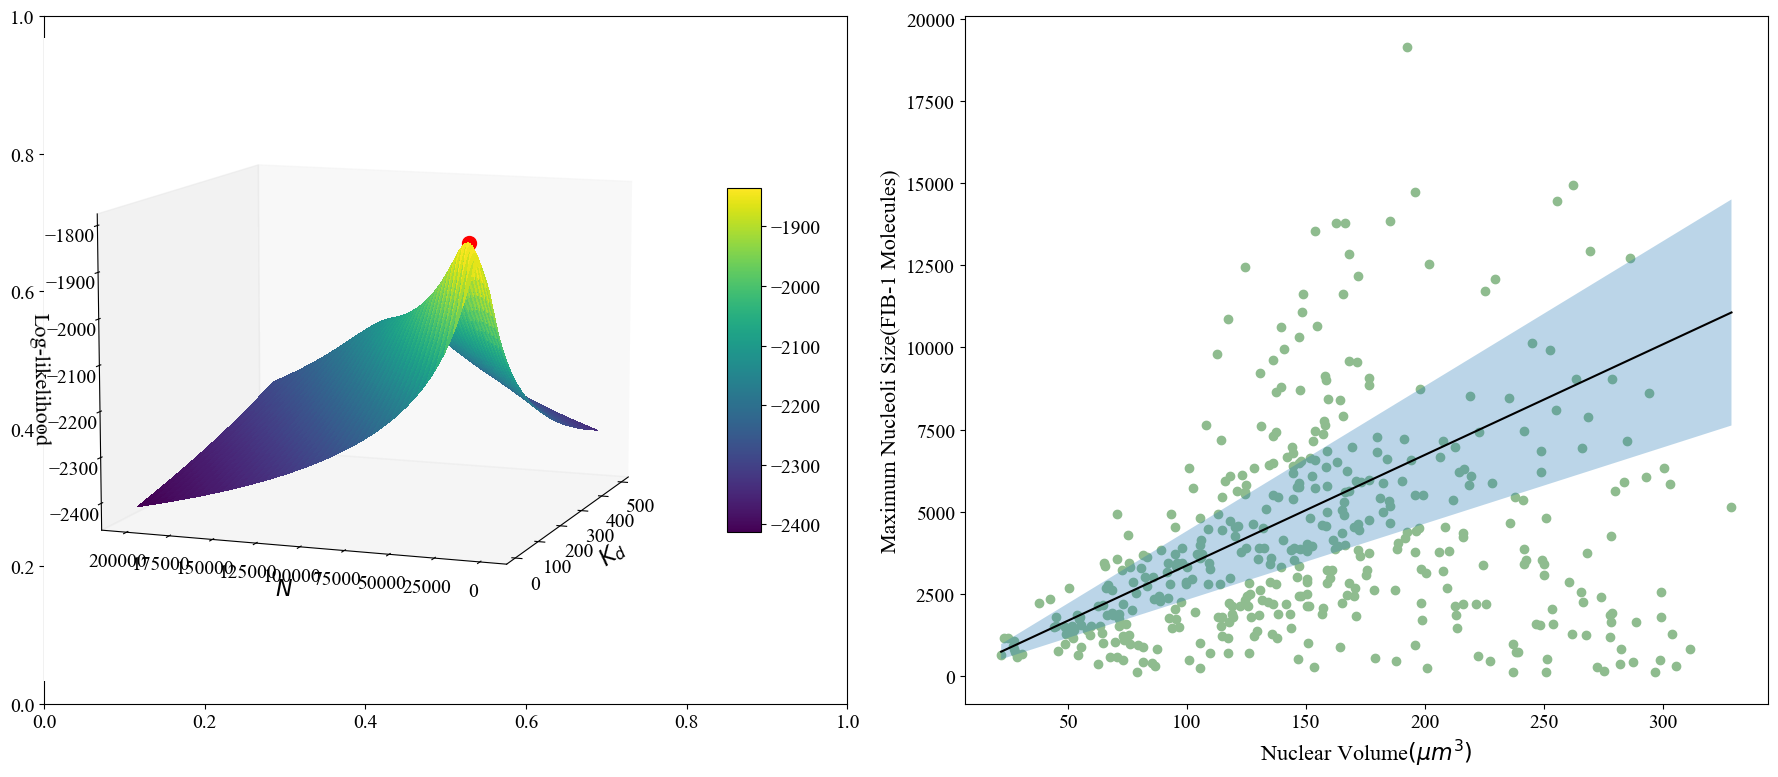

In [32]:
# Plotting
mpl.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# First Plot: 3D surface plot of log-likelihood
ax1 = fig.add_subplot(121, projection='3d')
surface = ax1.plot_surface(np.tile(dissociation_constant_grid, (num_N_AB8, 1)),
                           np.tile(N_AB8_grid.reshape(-1, 1), (1, num_dissociation_constants)),
                           likelihood_matrix, cmap='viridis', linewidth=0, antialiased=False)

# Highlight the maximum point
ax1.scatter(dissociation_constant_grid[max_likelihood_indices[1]], 
            N_AB8_grid[max_likelihood_indices[0]], 
            likelihood_matrix[max_likelihood_indices], 
            color='red', s=100, label='Maximum Point')

# Customize the appearance of the plot
ax1.set_xlabel(f'$K_d$', fontsize=16)
ax1.set_ylabel(f'$N$', fontsize=16)
ax1.set_zlabel('Log-likelihood', fontsize=16)

# Invert x and y axes
ax1.invert_xaxis()
ax1.invert_yaxis()

# Remove grid lines
ax1.xaxis.pane.fill = True
ax1.yaxis.pane.fill = True
ax1.zaxis.pane.fill = True
ax1.grid(False)

# Rotate the plot
ax1.view_init(elev=10, azim=20, roll=0)

# Add color bar
fig.colorbar(surface, ax=ax1, shrink=0.5, aspect=10)


## Second plot
V_all = np.load('Experimental_Data/Nuclear_volume_all_lineages.npy')
M_all = np.load('Experimental_Data/Nucleoli_intensity_all_lineages.npy')
M_all = M_all/39.4


V = V_all
M = M_all
###### Get Shaded Region #######

def size_M(x, C, kd):
    return (C - kd) * x

v_array = np.arange(0,max(V_ab8),0.1)
m_array = np.array([size_M(19000.00,55.00,i) for i in v_array])
m_array_1 = np.array([size_M(19000.00-1462.98,55.00-5.95,i) for i in v_array])
m_array_2 = np.array([size_M(19000.00+1462.98,55.00+5.95,i) for i in v_array])

# plt.subplot(1,2,1)
ax2.scatter(V,M,color='darkseagreen',label='Published Data ')

C = 88.66
Kd = 55
std_C = 16.41
std_Kd = 5.95


# Plot the data and the fitted line

ax2.plot(V, size_M(V, C,Kd), label='Fitted Curve', color='black')
ax2.fill_between(V, size_M(V, C - std_C, Kd - std_Kd), 
                 size_M(V, C + std_C, Kd + std_Kd), alpha=0.3,rasterized=True)

ax2.set_xlabel('Nuclear Volume$(\mu m^3)$',fontsize=16)
ax2.set_ylabel('Maximum Nucleoli Size(FIB-1 Molecules)',fontsize=16)
# plt.ylim([0,40000])
# plt.xlim([0,450])

# Show and save the plot
plt.tight_layout()
# plt.savefig('Figures/Chapter_5/Concentration_and_Likelihood.pdf', transparent=True, bbox_inches='tight')
plt.show()


## Figure S2

/var/folders/0d/bpjz6bj91vv8m15ms2svz2p01nft7w/T/ipykernel_38621/539657769.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


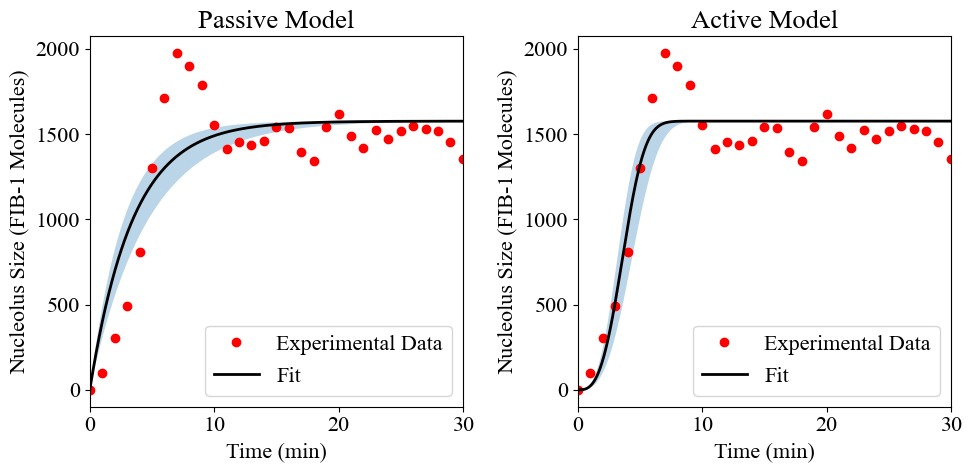

In [20]:
import matplotlib.pyplot as plt
import numpy as np
# import utils as utl  # Assuming you have a custom utility module named utils.py

# Set the font size and style
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(10, 5))

plt.subplot(1, 2, 1)

L = np.load(f"Experimental_Data/E16.npy", allow_pickle=True)
all_times = []
all_lengths = []
for j in range(len(L)):
    current = L[j]
    O = current.shape[0]
    Mexp = current[:, 1]  # Experimental data
    Texp = current[:, 0]  # Experimental time
    all_times.append(Texp)
    all_lengths.append(Mexp)

a, b, c = utl.get_mean_traj(all_times, all_lengths, time_interval=1, standard_deviation=False)

ps_T, ps_M = utl.passive_solution(kplus_passive=13.63, kdiss=55, Ntot=8307, V=93.7, delt=1e-3,
                                   t_end=35, m0=0, offset=False)

ps_T_1, ps_M_1 = utl.passive_solution(kplus_passive=13.63 - 1.96*1.85, kdiss=55, Ntot=8307, V=93.7,
                                      delt=1e-3, t_end=35, m0=0, offset=False)

ps_T_2, ps_M_2 = utl.passive_solution(kplus_passive=13.6 + 1.96*1.85, kdiss=55, Ntot=8307, V=93.7,
                                      delt=1e-3, t_end=35, m0=0, offset=False)

plt.fill_between(ps_T, list(ps_M_1), list(ps_M_2), alpha=0.3,rasterized=True)

plt.title('Passive Model')
plt.plot(a - a[0], b - b[0], 'o', label=f'Experimental Data', color='red')
plt.plot(ps_T, ps_M, c='k', lw=2, label='Fit')
plt.xlim(0, 30)
plt.xlabel('Time (min)')
plt.ylabel('Nucleolus Size (FIB-1 Molecules)')
plt.legend()

plt.subplot(1, 2, 2)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Increase the linewidth
plt.rcParams['lines.linewidth'] = 1.5

L = np.load(f"Experimental_Data/E16.npy", allow_pickle=True)
all_times = []
all_lengths = []
for j in range(len(L)):
    current = L[j]
    O = current.shape[0]
    Mexp = current[:, 1]  # Experimental data
    Texp = current[:, 0]  # Experimental time
    all_times.append(Texp)
    all_lengths.append(Mexp)

a, b, c = utl.get_mean_traj(all_times, all_lengths, time_interval=1, standard_deviation=False)

ac_T, ac_M = utl.active_solution(kplus_active=2.04, kdiss=55, Ntot=8307, V=93.7, delt=1e-3,
                                  t_end=35, t0=0, m0=0, offset=False)

ac_T_1, ac_M_1 = utl.active_solution(kplus_active=2.04 - 1.96*0.458, kdiss=55, Ntot=8307, V=93.7,
                                      delt=1e-3, t_end=35, t0=0, m0=0, offset=False)

ac_T_2, ac_M_2 = utl.active_solution(kplus_active=2.04 + 1.96*0.458, kdiss=55, Ntot=8307, V=93.7,
                                      delt=1e-3, t_end=35, t0=0, m0=0, offset=False)

plt.fill_between(ac_T, list(ac_M_1), list(ac_M_2), alpha=0.3,rasterized=True)

plt.plot(a - a[0], b - b[0], 'o', label=f'Experimental Data', color='red')
plt.plot(ac_T, ac_M, c='k', lw=2, label='Fit')
plt.legend()
plt.title('Active Model')
plt.xlabel('Time (min)')
plt.ylabel('Nucleolus Size (FIB-1 Molecules)')
plt.xlim(0, 30)



# ax.remove()
plt.tight_layout()

# Save the plot as EPS
# plt.savefig('Figures/Chapter_5/Active_Passive_MLE.eps', format='eps')
# plt.savefig('Figures/Chapter_5/Active_Passive_MLE.pdf')

# plt.savefig('Figures_For_Lishi/Active_Passive_MLE.pdf')
plt.show()


## Figure S3

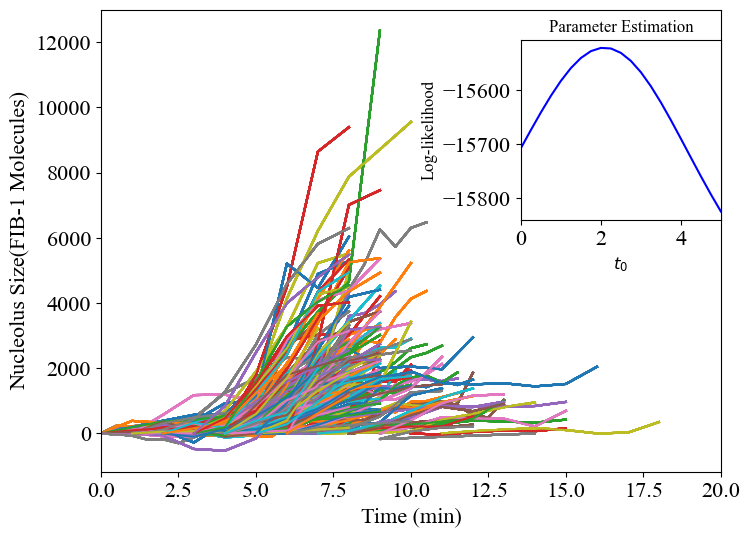

In [33]:
mpl.rcParams.update({'font.size':16})
M = np.load(f"Experimental_Data/AB16_assembly.npy",allow_pickle=True)

# Modified log-likelihood function
def loglikelihood_global(M, kplus_active, kdiss, Ntot, t0, V, m0, time):
    P = len(M)  # Number of data sets

    # Using params, compute one theoretical trajectory
    tpred, Mpred = nuc_odes_euler_PL(25, [kplus_active, kdiss, Ntot, t0, V, m0, time])

    sum_val = 0
    tot_pts = 0
    count = 0
    for j in range(P):
        current = M[j]
        O = current.shape[0]
        Mexp = current[:, 1]  # Experimental data
        Texp = current[:, 0]  # Experimental time
#         if all(i>=0 for i in Mexp):
        tot_pts += O

        # Correct time trajectories that begin before the average
        if Texp[0] < 0:
            Texp -= Texp[0]

        # Access correct elements from Mpred
        Mpred_order = []
        for idx in range(len(Texp)):
            Mpred_order.append(Mpred[np.where(tpred==Texp[idx])])  # Find closest value in tpred

        Mpred_order = np.array(Mpred_order)
        for i in range(O):
            sum_val += (Mexp[i] - Mpred_order[i]) ** 2


        count+=1
        plt.plot(Texp,Mexp,label='Exp')
        plt.xlabel('Time (min)')
        plt.ylabel('Nucleolus Size(FIB-1 Molecules)')
        plt.tick_params(axis='x')
        plt.tick_params(axis='y')
#         plt.plot(Texp,Mpred_order,label='Pred')
#         plt.legend()
    
    #print('total traj',count)
    L = -0.5 * (tot_pts - 1) * np.log(np.real(sum_val))
    

    return L

def nuc_odes_euler_PL(t_end, params):
    gamma, Kd, N, t0, V, m0, time = params

    # Set up time array
    delt = 0.001  # time step
    t = np.arange(0, t_end + delt, delt)
    m1 = np.zeros(len(t))  # nucleolus size
    m1[0] = m0  # initial size

    for i in range(len(t) - 1):
        if t[i] < t0:
            m1[i + 1] = m0
        else:
            m1[i + 1] = m0 * np.exp(-(2 * gamma / (3 * V)) * ((t[i] - t0) ** 3)) + (N - Kd * V) / 2 * (1 - np.exp(-(2 * gamma / (3 * V)) * ((t[i] - t0) ** 3)))

    t_pred = t
    M_pred = m1 - m0 #reducing the initial size from the prediction
    return t_pred, M_pred




# Known params
time = 23
m0 = 184.5193
V = 137.7
kdiss = 55
Ntot = 12209
kplus_active = 2.04
                                                                                               

# Set up likelihood function grid
deltaTmax = 0.25  # T_max
tmaxGrid = np.arange(0, 5+ deltaTmax, deltaTmax)  # Create an array of tmax values
m = len(tmaxGrid)
likelihood = np.ones(m)  # Initialize an array to store likelihood values


# Loop through all values for t0
plt.figure(figsize=(8,6))
for k in range(m):
    likelihood[k] = loglikelihood_global(M, kplus_active, kdiss, Ntot, tmaxGrid[k], V, m0, time)

plt.xlim(0,20)
    
inset_ax = plt.axes([0.65, 0.53, 0.25, 0.3])  # Define inset position and size [x, y, width, height]
        #inset_plot = inset_ax.errorbar(raw_times_s[big1_idx], raw_lengths_s[big1_idx], raw_errors_s[big1_idx], color=colors[big1_idx], fmt='-o',label='big1', capsize=4)

inset_plot = inset_ax.plot(tmaxGrid, np.real(likelihood),color = 'blue')

#Customize the inset axis
inset_ax.set_xlabel(r'$t_0$',fontsize=12)
inset_ax.set_ylabel('Log-likelihood',fontsize=12)
inset_ax.set_xlim([0,5])
inset_ax.set_title("Parameter Estimation",fontsize=12)
# plt.savefig('AB16_mle_1.png', dpi=300, bxbo_inches='tight')


# Compute error on likelihood estimates
del_likelihood = np.gradient(np.gradient(likelihood, deltaTmax),deltaTmax)  # Calculate second derivative
tmaxIdx = np.argmax(likelihood)  # Find index of maximum likelihood value
Tmax_mle = tmaxGrid[tmaxIdx]  # Get the corresponding T_max value
Tmax_err_mle = np.sqrt(-1 / del_likelihood[tmaxIdx])  # Calculate error



# plt.savefig('Figures/Chapter_5/AB16_t0_MLE.pdf', transparent=True, bbox_inches='tight')
# plt.tight_layout()
plt.show()  # Show the generated plots

## Figure S4

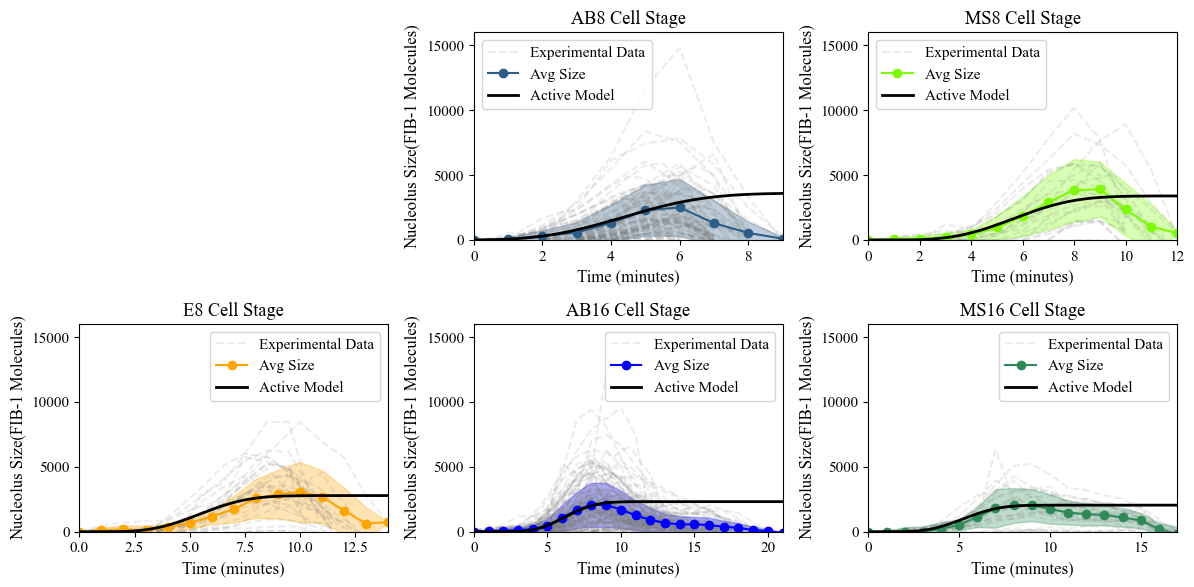

In [34]:

plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'Times New Roman'

labels = ['AB8', 'MS8', 'E8', 'AB16', 'MS16', 'E16','IMA3','ANI2','BIG1']
colors = ['#2b5d87','lawngreen', 'orange', 'blue','seagreen','red','#86b2d8','#3d84bf','royalblue','#2b5d87']
t0_s = [-0.4, 1, 1.1, 2.1,1.3, 0,-2.7,-2.5,-3.4]

ntots = [19000, 17874, 14673, 12209, 10781, 8307,19000,19000,19000,19000]
volumes = [214.3, 201.6, 165.5, 137.7,121.6,93.7,148.8767215,186.9308994,311.3973321,214.3]

plt.figure(figsize=(12,6))

for i in range(len(labels)-4):
    L = np.load(f"Experimental_Data/{labels[i]}.npy",allow_pickle=True)
    all_times = []
    all_lengths = []
    plt.subplot(2,3,i+2)
    for j in range(len(L)):
        current = L[j]
        O = current.shape[0]
        Mexp = current[:, 1]  # Experimental data
        Texp = current[:, 0]  # Experimental time
        
        Texp = np.round(Texp,2)

                
        if Texp[0] < 0:
            Texp -= Texp[0]
            
        all_times.append(Texp)
        all_lengths.append(Mexp)
        plt.plot(all_times[-1],all_lengths[-1],'--',color='grey',alpha=0.15)
    
    plt.plot(all_times[-1],all_lengths[-1],'--',color='grey',alpha=0.15,label='Experimental Data')

    a,b,c = utl.get_mean_traj(all_times,all_lengths,1,standard_deviation=True)
    b = np.array(b)
    c = np.array(c)

#     plt.errorbar(a - a[0], b - b[0], yerr=c, fmt='-o', label=f'{labels[i]} Cell Stage', color=colors[i],
#                  lw=1, markersize=4, capsize=5, capthick=1, elinewidth=1, markeredgewidth=1)

    plt.plot(a , b, '-o', color=colors[i],label='Avg Size')
    plt.fill_between(a , b  - c, b  + c, alpha=0.3, color=colors[i])
    
    ac_T, ac_M = utl.active_solution(kplus_active=2.0, kdiss=55, Ntot=ntots[i], V=volumes[i], delt=1e-3, 
                                 t_end=35,t0=t0_s[i], m0=0, offset=False)
    
    plt.plot(ac_T,ac_M,c='k',lw=2,label='Active Model')
    
    plt.title(f'{labels[i]} Cell Stage')
    plt.xlabel('Time (minutes)',fontsize=12)
    plt.ylabel('Nucleolus Size(FIB-1 Molecules)',fontsize=12)
    plt.legend(fontsize=11)
    plt.ylim(0,16000)
    plt.xlim(0,np.max(a))

# plt.savefig('Figures/Chapter_1/all_lineages.pdf', transparent=True, bbox_inches='tight')
plt.tight_layout()
plt.show()

## Figure S5

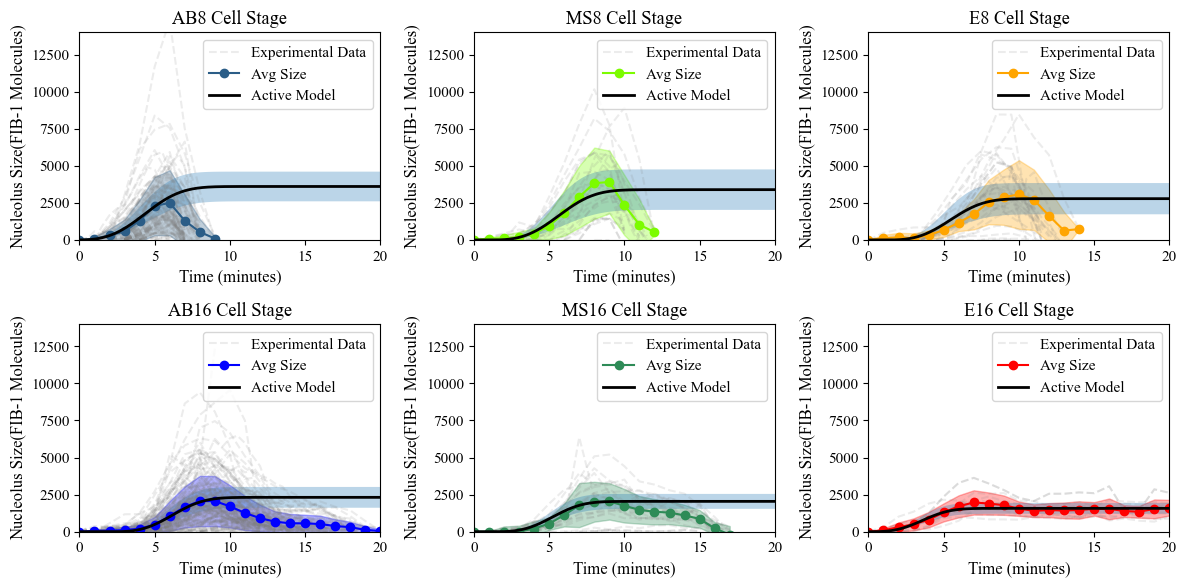

In [35]:

plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'Times New Roman'

labels = ['AB8', 'MS8', 'E8', 'AB16', 'MS16', 'E16','IMA3','ANI2','BIG1']
colors = ['#2b5d87','lawngreen', 'orange', 'blue','seagreen','red','#86b2d8','#3d84bf','royalblue','#2b5d87']
t0_s = [-0.4, 1, 1.1, 2.1,1.3, 0,-3.2,-2.5,-3.4]

ntots = [19000, 17874, 14673, 12209, 10781, 8307,19000,19000,19000,19000]
volumes = [214.3, 201.6, 165.5, 137.7,121.6,93.7,148.8767215,186.9308994,311.3973321,214.3]
volume_uncert = [36.4,49.6,38.3,25.5,18.3,13.3]

plt.figure(figsize=(12,6))

for i in range(len(labels)-3):
    L = np.load(f"Experimental_Data/{labels[i]}.npy",allow_pickle=True)
    all_times = []
    all_lengths = []
    plt.subplot(2,3,i+1)
    for j in range(len(L)):
        current = L[j]
        O = current.shape[0]
        Mexp = current[:, 1]  # Experimental data
        Texp = current[:, 0]  # Experimental time
        
        Texp = np.round(Texp,2)
                
        if Texp[0] < 0:
            Texp -= Texp[0]
            
        all_times.append(Texp)
        all_lengths.append(Mexp)
        plt.plot(all_times[-1],all_lengths[-1],'--',color='grey',alpha=0.15)
    
    plt.plot(all_times[-1],all_lengths[-1],'--',color='grey',alpha=0.15,label='Experimental Data')

    a,b,c = utl.get_mean_traj(all_times,all_lengths,1,standard_deviation=True)
    b = np.array(b)
    c = np.array(c)

#     plt.errorbar(a - a[0], b - b[0], yerr=c, fmt='-o', label=f'{labels[i]} Cell Stage', color=colors[i],
#                  lw=1, markersize=4, capsize=5, capthick=1, elinewidth=1, markeredgewidth=1)

    plt.plot(a , b, '-o', color=colors[i],label='Avg Size')
    plt.fill_between(a , b  - c, b  + c, alpha=0.3, color=colors[i],rasterized=True)
    
    
    
    
    ac_T, ac_M = utl.active_solution(kplus_active=2.0, kdiss=55, Ntot=ntots[i], V=volumes[i], delt=1e-3, 
                                 t_end=35,t0=t0_s[i], m0=b[0], offset=False)
    
    
    ac_T_1, ac_M_1 = utl.active_solution(kplus_active=2.04, kdiss=55, Ntot=ntots[i], V=volumes[i]-volume_uncert[i]
                                         ,delt=1e-3,t_end=35,t0=t0_s[i], m0=b[0], offset=False)
    

    ac_T_2, ac_M_2 = utl.active_solution(kplus_active=2.04, kdiss=55, Ntot=ntots[i], V=volumes[i]+volume_uncert[i]
                                         ,delt=1e-3,t_end=35,t0=t0_s[i], m0=b[0], offset=False)
    
    plt.plot(ac_T,ac_M,c='k',lw=2,label='Active Model')
    

    plt.fill_between(ac_T, ac_M_1, ac_M_2, alpha=0.3,rasterized=True)
    
    plt.title(f'{labels[i]} Cell Stage')
    plt.xlabel('Time (minutes)',fontsize=12)
    plt.ylabel('Nucleolus Size(FIB-1 Molecules)',fontsize=12)
    plt.legend(fontsize=11)
    plt.ylim(0,14000)
    plt.xlim(0,20)
plt.tight_layout()
# plt.savefig('Figures/Chapter_5/all_lineages_STD.pdf', transparent=True, bbox_inches='tight')

plt.show()

## Figure S6

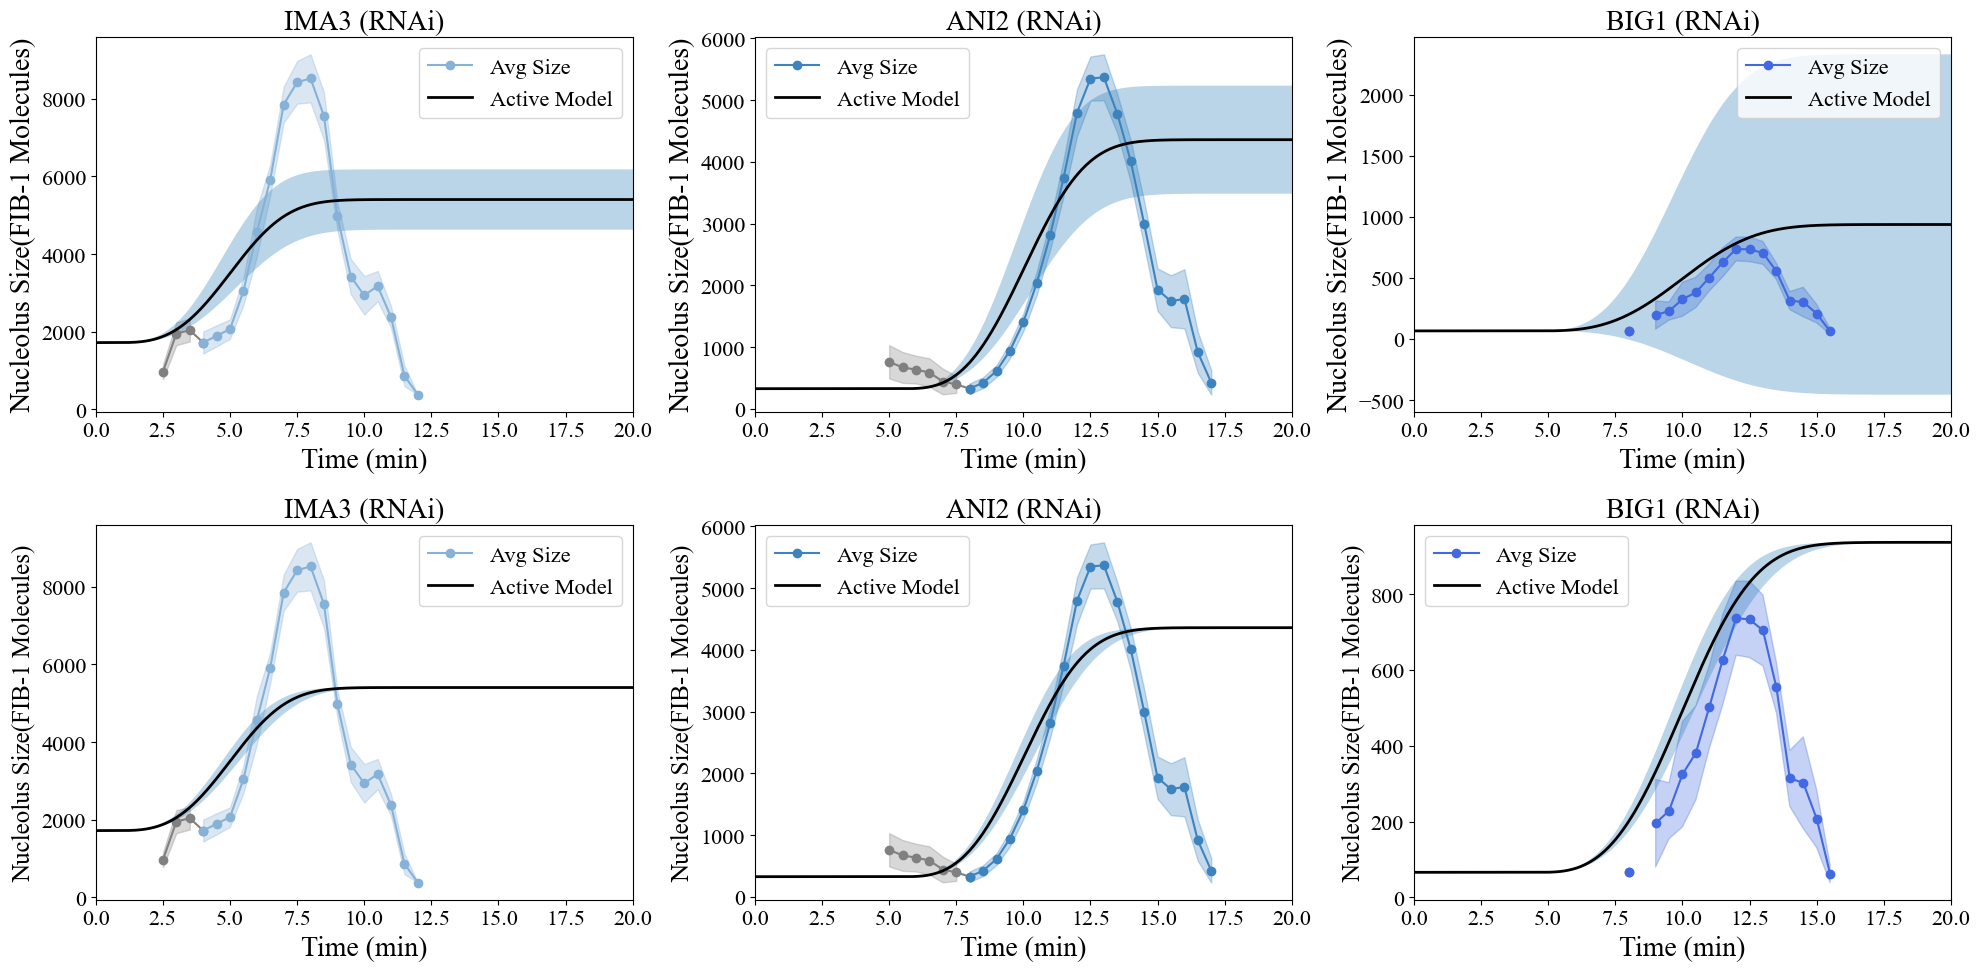

In [36]:
mpl.rcParams.update({'font.size':16})
plt.figure(figsize=(20,10))
volume_uncert = [28.26045455,31.79761422,50.63549832]

labels = ['IMA3','ANI2','BIG1']
colors = ['#86b2d8','#3d84bf','royalblue']
t0_s = [-3.2,-2.5,-3.4]

ntots = [19000,19000,19000]
volumes = [148.8767215,186.9308994,311.3973321]
start_p = [3, 6, 0]

for i in range(0,len(labels)):
    L = np.load(f"Experimental_Data/{labels[i]}_exp.npy",allow_pickle=True)
    all_times = []
    all_lengths = []
    for j in range(len(L)):
        current = L[j]
        O = current.shape[0]
        Mexp = current[:, 1]  # Experimental data
        Texp = current[:, 0]  # Experimental time
        
        Texp = np.round(Texp,2)
                
        if Texp[0] < 0:
            Texp -= Texp[0]
            
        all_times.append(Texp)
        all_lengths.append(Mexp)


    plt.subplot(2,3,i+1)
    a,b,c = utl.get_mean_traj(all_times,all_lengths,time_interval=0.5,standard_deviation=False)
    
    a = np.array(a)
    b = np.array(b)
    
    #grey area
    plt.plot(a[:start_p[i]+1] , b[:start_p[i]+1], '-o', color='grey')
    plt.fill_between(a[:start_p[i]] , b[:start_p[i]]  - c[:start_p[i]], b[:start_p[i]]  + c[:start_p[i]], alpha=0.3, color='grey',rasterized=True)
    
    #after grey
    plt.plot(a[start_p[i]:] , b[start_p[i]:], '-o', color=colors[i],label='Avg Size')
    plt.fill_between(a[start_p[i]:] , b[start_p[i]:]  - c[start_p[i]:], b[start_p[i]:]  + c[start_p[i]:], alpha=0.3, color=colors[i],rasterized=True)
    
    
    
    ac_T, ac_M = utl.active_solution(kplus_active=2.0, kdiss=55, Ntot=ntots[i], V=volumes[i], delt=1e-3, 
                                 t_end=35,t0=a[start_p[i]]+t0_s[i], m0=b[start_p[i]], offset=False)
    
    
    ac_T_1, ac_M_1 = utl.active_solution(kplus_active=2.04, kdiss=55, Ntot=ntots[i], V=volumes[i]-volume_uncert[i]
                                         ,delt=1e-3,t_end=35,t0=a[start_p[i]]+t0_s[i], m0=b[start_p[i]], offset=False)
    

    ac_T_2, ac_M_2 = utl.active_solution(kplus_active=2.04, kdiss=55, Ntot=ntots[i], V=volumes[i]+volume_uncert[i]
                                         ,delt=1e-3,t_end=35,t0=a[start_p[i]]+t0_s[i], m0=b[start_p[i]], offset=False)
    
    
    plt.plot(ac_T,ac_M,c='k',lw=2,label='Active Model')

    # Plot shaded region between V_1 and V_2
    plt.fill_between(ac_T, ac_M_1, ac_M_2, alpha=0.3,rasterized=True)

    plt.title(f'{labels[i]} (RNAi)', fontsize=20)
    # Add labels and title
    plt.xlim(0,20)
    plt.xlabel('Time (min)', fontsize=20)
    plt.ylabel('Nucleolus Size(FIB-1 Molecules)', fontsize=20)

    plt.legend(loc=0)
    
    
    
    
###############################################################################################################
volume_uncert = [28.26045455,31.79761422,50.63549832]

labels = ['IMA3','ANI2','BIG1']
colors = ['#86b2d8','#3d84bf','royalblue']
t0_s = [-3.2,-2.5,-3.4]

ntots = [19000,19000,19000]
volumes = [148.8767215,186.9308994,311.3973321]
start_p = [3, 6, 0]

for i in range(0,len(labels)):
    L = np.load(f"Experimental_Data/{labels[i]}_exp.npy",allow_pickle=True)
    all_times = []
    all_lengths = []
    for j in range(len(L)):
        current = L[j]
        O = current.shape[0]
        Mexp = current[:, 1]  # Experimental data
        Texp = current[:, 0]  # Experimental time
                
#         if Texp[0] < 0:
#             Texp -= Texp[0]
            
        all_times.append(Texp)
        all_lengths.append(Mexp)


    plt.subplot(2,3,i+4)
    a,b,c = utl.get_mean_traj(all_times,all_lengths,time_interval=0.5,standard_deviation=False)
    
    a = np.array(a)
    b = np.array(b)
    

    
    #grey area
    plt.plot(a[:start_p[i]+1] , b[:start_p[i]+1], '-o', color='grey')
    plt.fill_between(a[:start_p[i]] , b[:start_p[i]]  - c[:start_p[i]], b[:start_p[i]]  + c[:start_p[i]], alpha=0.3, color='grey',rasterized=True)
    
    #after grey
    plt.plot(a[start_p[i]:] , b[start_p[i]:], '-o', color=colors[i],label='Avg Size')
    plt.fill_between(a[start_p[i]:] , b[start_p[i]:]  - c[start_p[i]:], b[start_p[i]:]  + c[start_p[i]:], alpha=0.3, color=colors[i],rasterized=True)
    
    
    ac_T, ac_M = utl.active_solution(kplus_active=2.0, kdiss=55, Ntot=ntots[i], V=volumes[i], delt=1e-3, 
                                 t_end=35,t0=a[start_p[i]]+t0_s[i], m0=b[start_p[i]], offset=False)
    
    
    ac_T_1, ac_M_1 = utl.active_solution(kplus_active=2.04-0.458, kdiss=55, Ntot=ntots[i], V=volumes[i]
                                         ,delt=1e-3,t_end=35,t0=a[start_p[i]]+t0_s[i], m0=b[start_p[i]], offset=False)
    

    ac_T_2, ac_M_2 = utl.active_solution(kplus_active=2.04+0.458, kdiss=55, Ntot=ntots[i], V=volumes[i]
                                         ,delt=1e-3,t_end=35,t0=a[start_p[i]]+t0_s[i], m0=b[start_p[i]], offset=False)
    
    
    plt.plot(ac_T,ac_M,c='k',lw=2,label='Active Model')

    # Plot shaded region between V_1 and V_2
    plt.fill_between(ac_T, ac_M_1, ac_M_2, alpha=0.3,rasterized=True)

    plt.title(f'{labels[i]} (RNAi)', fontsize=20)
    # Add labels and title
    plt.xlim(0,20)
    plt.xlabel('Time (min)', fontsize=20)
    plt.ylabel('Nucleolus Size(FIB-1 Molecules)', fontsize=18)

    plt.legend(loc=0)



plt.tight_layout()

# plt.savefig('Figures/Chapter_5/Kplus_Volume_uncert.pdf', transparent=True, bbox_inches='tight')
# plt.savefig('Figures_For_Lishi/Kplus_Volume_uncert.pdf', transparent=True, bbox_inches='tight')
plt.show()
